Import the libraries

In [1]:
import collections
from ortools.sat.python import cp_model

Define data for problem

In [ ]:
import json
with open('hayday_goods.json','r') as file:
    raw_data = json.load(file)

with open('my_machines.json','r') as file:
    my_machines = json.load(file)

all_machines = []

for item_name, details in raw_data.items():
    if(details['machine'] not in all_machines):
        all_machines.append(details['machine'])

machines_count = len(all_machines)

declare the model

In [3]:
model = cp_model.CpModel()

Define the variables

In [4]:
goods_data = ['Feta salad']#martin

task_type = collections.namedtuple("task_type", "start end interval machine")

all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

queue = []
horizon = 1000000                                                                            
id = 0
id_to_name = []
id_to_machine = []
for good in goods_data:
    id_to_name.append(good)
    queue.append((good, id,-1))
    id += 1

while len(queue) != 0:
    current_name, current_id, parent_id = queue.pop(0)
    start_var = model.new_int_var(0,horizon,"start"+str(current_id))
    end_var = model.new_int_var(0,horizon,"end"+str(current_id))
    interval_var = model.new_interval_var(
        start_var, raw_data[current_name]['time'], end_var, "interval"+str(current_id)
    )
    machine_var = model.new_int_var(0,len(all_machines),"machine"+str(current_id))

    presences = []
    num_specific_my_machines = my_machines[raw_data[current_name]['machine']]['number']
    for i in range(num_specific_my_machines):
        l_start_var = model.new_int_var(0,horizon,"l_start"+ str(i)+str(current_id))
        l_end_var = model.new_int_var(0,horizon,"l_end"+str(i)+str(current_id))
        l_presence = model.new_bool_var(f"l_presence_Field_{str(i)}_{str(current_id)}")
        l_interval_var = model.new_optional_interval_var(
            l_start_var, raw_data[current_name]['time'], l_end_var, l_presence, "interval"+str(current_id)
        )
        model.Add(start_var == l_start_var).OnlyEnforceIf(l_presence)
        model.Add(end_var == l_end_var).OnlyEnforceIf(l_presence)
        model.Add(machine_var == i).OnlyEnforceIf(l_presence)
        presences.append(l_presence)
        machine_to_intervals[raw_data[current_name]['machine']+str(i)].append(l_interval_var)
    model.add_exactly_one(presences)
   
     
    all_tasks[current_id] = task_type(
            start=start_var, end=end_var, interval=interval_var, machine = machine_var
    )
    if(parent_id != -1):
        model.add(
            all_tasks[parent_id].start >= all_tasks[current_id].end  
        )

    for ing, ing_qty in raw_data[current_name]['ingredients'].items():
        if(ing == current_name):
            break
        else:
            for i in range(ing_qty):
                id_to_name.append(ing)
                queue.append((ing, id, current_id))
                id += 1
                
                


Define the constraints

In [ ]:
for machine in machine_to_intervals.keys():
    model.add_no_overlap(machine_to_intervals[machine])

Define the objective

In [6]:
obj_var = model.new_int_var(0, horizon, "makespan")

model.add_max_equality(
    obj_var,
    [all_tasks[i].end for i in range(id)],
)

model.minimize(obj_var)

invoke solver

In [ ]:
solver = cp_model.CpSolver()
status = solver.solve(model)


['Feta salad', 'Goat cheese', 'Goat cheese', 'Lettuce', 'Lettuce', 'Lettuce', 'Olive', 'Olive', 'Roasted tomatoes', 'Goat milk', 'Goat milk', 'Goat milk', 'Goat milk', 'Tomato', 'Tomato', 'Goat feed', 'Goat feed', 'Goat feed', 'Goat feed', 'Carrot', 'Carrot', 'Corn', 'Wheat', 'Carrot', 'Carrot', 'Corn', 'Wheat', 'Carrot', 'Carrot', 'Corn', 'Wheat', 'Carrot', 'Carrot', 'Corn', 'Wheat']


display results

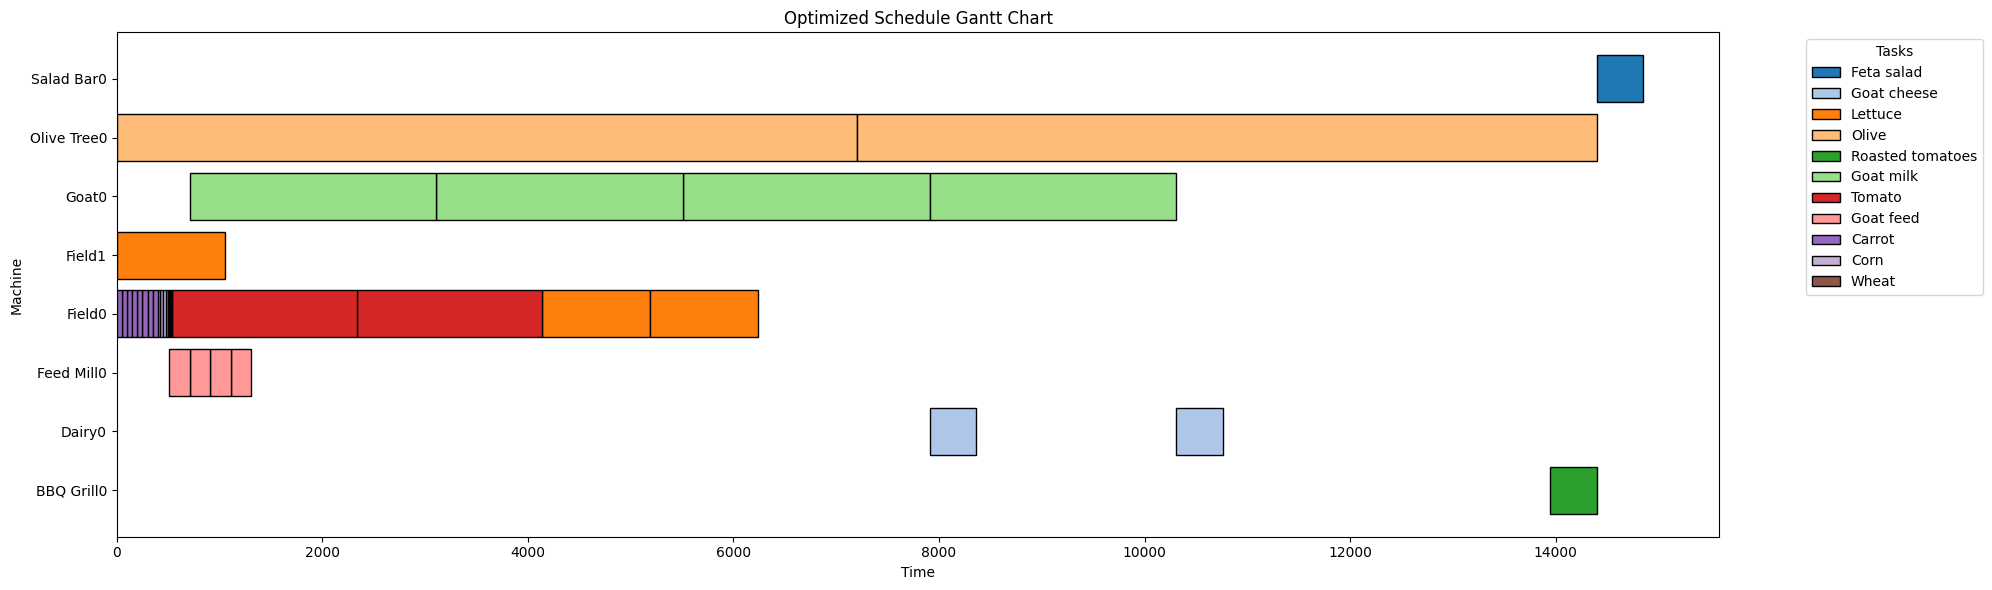

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    # Collect schedule data for plotting
    schedule_data = []
    for i in range(id):
        start = solver.Value(all_tasks[i].start)
        end = solver.Value(all_tasks[i].end)
        machine = raw_data[id_to_name[i]]['machine']+ str(solver.Value(all_tasks[i].machine))
        schedule_data.append((id_to_name[i], start, end, machine))

    # Build Gantt chart
    scale = 5  # Scale factor for time units
    fig, ax = plt.subplots(figsize=(20, 6))  # Wider figure for visibility

    # Unique machine list and positions
    machines = sorted(set(item[3] for item in schedule_data))
    y_positions = {machine: idx for idx, machine in enumerate(machines)}

    # Assign colors by task name
    colors = {}
    for idx, (task_name, _, _, _) in enumerate(schedule_data):
        if task_name not in colors:
            colors[task_name] = plt.cm.tab20(len(colors) % 20)

    # Draw bars with scaling
    for task_name, start, end, machine in schedule_data:
        ax.barh(
            y_positions[machine],
            (end - start) * scale,
            left=start * scale,
            color=colors[task_name],
            edgecolor='black'
        )
        """ax.text(
            ((start + end) / 2) * scale,
            y_positions[machine],
            task_name,
            ha='center',
            va='center',
            fontsize=8,
            color='white'
        )"""

    # Create legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=task)
                       for task, color in colors.items()]
    ax.legend(handles=legend_elements, title="Tasks", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format chart
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel(f"Time")
    ax.set_ylabel("Machine")
    ax.set_title("Optimized Schedule Gantt Chart")
    plt.tight_layout()
    plt.show()
